In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def log_scraper(filename: str) -> Dict:
    print(filename)
    "parses a log file and returns a dictionary of time statistics"
    stats = {i: [] for i in range(5)}
    with open(filename) as f:
        lines = f.readlines()

    run = 0
    for j,line in enumerate(lines):
        if "Run" in line:
            run += 1
            continue
        tokens = line.split(" ")
        timestamp = tokens[1]
        stats[run].append(timestamp)

    return stats

In [3]:
def timestamp_diff(timestamps: List) -> np.ndarray:
    """returns np array of time differences in seconds between epochs stamped in H:M:S.MS format.
    Assumes all jobs take less than a day of total compute time
    """
    diffs = []
    i_0, i_1 = 0, 1
    for _ in range(len(timestamps) - 1):
        t_i, t_f = timestamps[i_0], timestamps[i_1]
        t_i = t_i.split(":")
        t_f = t_f.split(":")
        h_i, m_i, s_i = float(t_i[0]), float(t_i[1]), float(t_i[2])
        h_f, m_f, s_f = float(t_f[0]), float(t_f[1]), float(t_f[2])
        initial = (h_i*3600.0) + (m_i*60.0) + (s_i)
        final = (h_f*3600.0) + (m_f*60.0) + (s_f)

        if final < initial:
            final =+ 86400 # adjust for mod 24 hour day
        diffs.append(final-initial)
        i_0 +=1
        i_1 +=1
    return np.array(diffs)

In [4]:
def get_stats(fn_template: str, setups: Tuple[int,int], runs, root: str="pvc_reddit") -> Tuple[np.ndarray, np.ndarray]:
    """This takes an average of 3 independent jobs - it only makes sense if all jobs have the same number of epochs"""
    epoch_avgs = []
    epoch_vars = []
    for setup in setups:
        all_run_diffs = []
        for run in runs:
            stats = log_scraper(root + f"run_{run}/" + fn_template.format(setup[0], setup[1]))
            all_run_diffs.append(np.array([timestamp_diff(stats[i]) for i in range(1,5)]).flatten())
        all_run_diffs = np.array(all_run_diffs).flatten()
        epoch_avg = np.average(all_run_diffs)
        epoch_var = np.var(all_run_diffs)
        epoch_avgs.append(epoch_avg)
        epoch_vars.append(epoch_var)
    return np.array(epoch_avgs), np.array(epoch_vars)

In [8]:
a100_setups = [(1,1),(1,2),(1,4),(2,8),(4,16),(6,24)]
com_setups = [(1,2),(1,4),(1,8),(2,16),(4,32),(6,48)]

com_temp = "reddit_pyg_pvc_nodes_{0}_gpus_{1}_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log"
com_epoch_avgs, com_epoch_vars = get_stats(com_temp, com_setups, runs=[0], root="pvc_cheb/")

a100_temp = "reddit_pyg_gpu-a100_nodes_{0}_gpus_{1}_batchsize_2048_epochs_25_optimize_False_dtype_f32.log"
a100_epoch_avgs, a100_epoch_vars = get_stats(a100_temp, a100_setups, runs=[0], root="a100_cheb/")


pvc_cheb/run_0/reddit_pyg_pvc_nodes_1_gpus_2_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_cheb/run_0/reddit_pyg_pvc_nodes_1_gpus_4_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_cheb/run_0/reddit_pyg_pvc_nodes_1_gpus_8_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_cheb/run_0/reddit_pyg_pvc_nodes_2_gpus_16_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_cheb/run_0/reddit_pyg_pvc_nodes_4_gpus_32_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
pvc_cheb/run_0/reddit_pyg_pvc_nodes_6_gpus_48_batchsize_1024_epochs_25_optimize_False_dtype_f32_hierarchy_COMPOSITE.log
a100_cheb/run_0/reddit_pyg_gpu-a100_nodes_1_gpus_1_batchsize_2048_epochs_25_optimize_False_dtype_f32.log
a100_cheb/run_0/reddit_pyg_gpu-a100_nodes_1_gpus_2_batchsize_2048_epochs_25_optimize_False_dtype_f32.log
a100_cheb/run_0/reddit_pyg_gpu-a100_nodes_1_gpus_4_batchsize_2048_epochs_

In [10]:
gpu_array = np.array([1,2,4,8,16,28])
cheb_training_data = np.stack([gpu_array.T, a100_epoch_avgs.T, com_epoch_avgs.T])
print(cheb_training_data.T)
np.savetxt("cheb_train_f32.csv", cheb_training_data.T, delimiter="   ",fmt='%1.3f')

[[ 1.         46.86864583 73.58215625]
 [ 2.         23.91671875 38.0385625 ]
 [ 4.         12.3774375  19.53761458]
 [ 8.          6.41033333 10.33078125]
 [16.          3.60241667  5.53077083]
 [28.          2.1373125   3.10466667]]


In [11]:
resnet_training_data = np.stack([gpu_array.T,
                                 a100_epoch_avgs[0]/a100_epoch_avgs.T,
                                 com_epoch_avgs[0]/com_epoch_avgs.T])
print(resnet_training_data.T)
np.savetxt("cheb_speedup_f32.csv", resnet_training_data.T, delimiter="   ",fmt='%1.3f')

[[ 1.          1.          1.        ]
 [ 2.          1.95966037  1.93440949]
 [ 4.          3.78661947  3.76617913]
 [ 8.          7.31142101  7.12261294]
 [16.         13.0103345  13.30414123]
 [28.         21.92877543 23.70050126]]


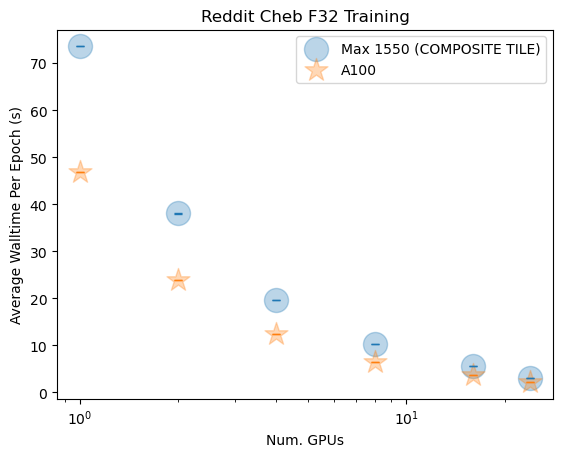

In [13]:
n_gpus = [i[-1] for i in a100_setups]

plt.errorbar(n_gpus, com_epoch_avgs, yerr=com_epoch_vars,linestyle="None", capsize=3)
plt.scatter(n_gpus, com_epoch_avgs, s=300, label="Max 1550 (COMPOSITE TILE)", alpha=0.3)

plt.errorbar(n_gpus, a100_epoch_avgs, yerr=a100_epoch_vars,linestyle="None", capsize=3)
plt.scatter(n_gpus, a100_epoch_avgs, s=300, label="A100", alpha=0.3, marker="*")

plt.xscale("log")
plt.title("Reddit Cheb F32 Training")
plt.ylabel("Average Walltime Per Epoch (s)")
plt.xlabel("Num. GPUs")
plt.legend(loc='best')
plt.show()


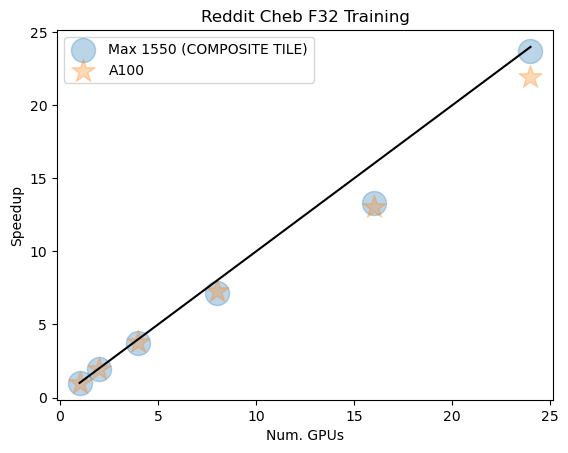

In [14]:

plt.scatter(n_gpus, com_epoch_avgs[0]/com_epoch_avgs, s=300, label="Max 1550 (COMPOSITE TILE)", alpha=0.3)
plt.scatter(n_gpus, a100_epoch_avgs[0]/a100_epoch_avgs, s=300, label="A100", marker="*", alpha=0.3)

plt.plot(n_gpus,n_gpus, color='black')
plt.title("Reddit Cheb F32 Training")
plt.ylabel("Speedup")
plt.xlabel("Num. GPUs")
plt.legend(loc='best')
plt.show()